## Setup


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2 xgboost==1.5.0


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import warnings

In [ ]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Data


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/sohaibs project/daily_cp_activity_dataset.csv')


In [ ]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

        date  courier_partners_online  temperature  relative_humidity  \
0 2021-05-01                       49        18.27               0.57   
1 2021-05-02                      927        19.88               0.55   
2 2021-05-03                       40        16.88               0.60   
3 2021-05-04                       51        21.88               0.53   
4 2021-05-05                       50        21.11               0.54   

   precipitation  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     761 non-null    datetime64[ns]
 1   courier_partners_online  761 non-null    int64         
 2   temperature              731 non-null    float64       
 3   relative_humidity        761 non-

# EDA


In [ ]:
# Check for missing values
print(df.isnull().sum())

date                        0
courier_partners_online     0
temperature                30
relative_humidity           0
precipitation               5
dtype: int64


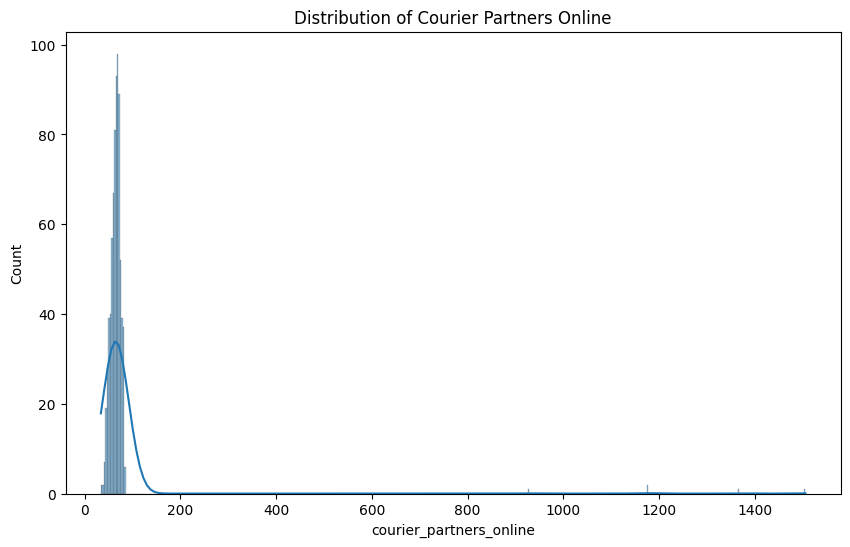

In [ ]:
# Plotting distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['courier_partners_online'], kde=True)
plt.title('Distribution of Courier Partners Online')
plt.show()

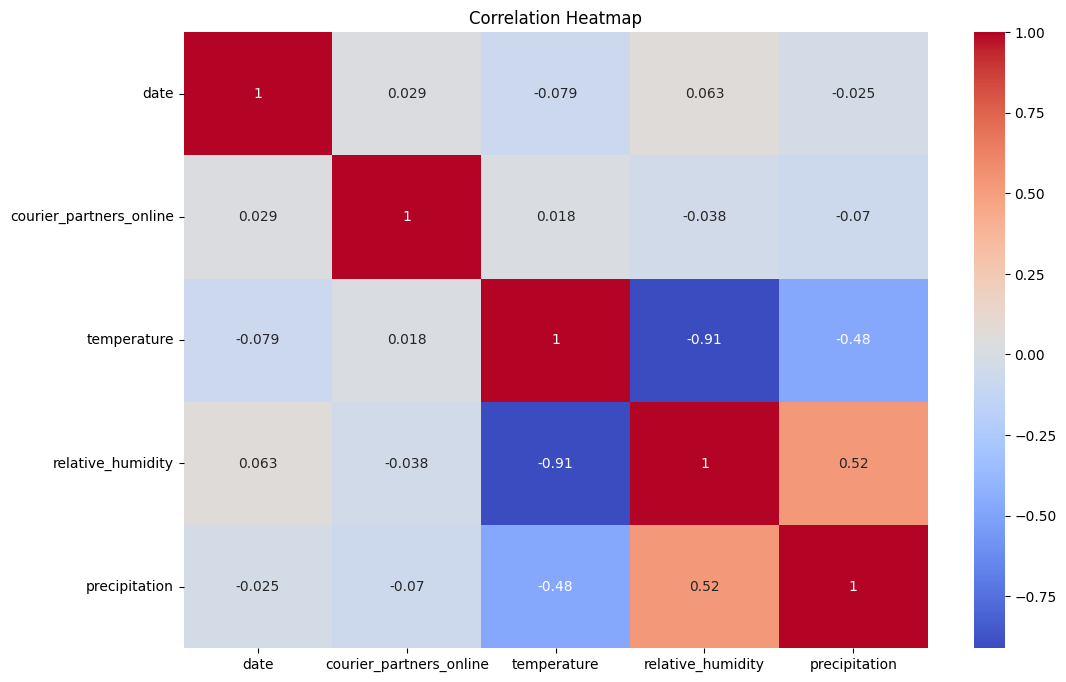

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# Data Processing


In [ ]:
# Feature Engineering
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['lag_1'] = df['courier_partners_online'].shift(1)
df['lag_7'] = df['courier_partners_online'].shift(7)
df['rolling_avg_3'] = df['courier_partners_online'].rolling(window=3).mean()
df['rolling_avg_7'] = df['courier_partners_online'].rolling(window=7).mean()
df['exp_moving_avg_3'] = df['courier_partners_online'].ewm(span=3, adjust=False).mean()
df['exp_moving_avg_7'] = df['courier_partners_online'].ewm(span=7, adjust=False).mean()
df['weekly_growth'] = df['courier_partners_online'].pct_change(periods=7)


In [ ]:
# Drop rows with NaN values
df.dropna(inplace=True)

In [ ]:
# Feature Selection
features_main = ['temperature', 'relative_humidity', 'precipitation',
                 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                 'lag_1', 'lag_7', 'rolling_avg_3', 'rolling_avg_7',
                 'exp_moving_avg_3', 'exp_moving_avg_7']
target_main = 'courier_partners_online'
features_growth = features_main
target_growth = 'weekly_growth'

In [ ]:
# Data Preprocessing
def prepare_data(features, target):
    X = df[features]
    y = df[target]
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)
    return X_train, X_test, y_train, y_test, scaler

X_train_main, X_test_main, y_train_main, y_test_main, scaler_main = prepare_data(features_main, target_main)
X_train_growth, X_test_growth, y_train_growth, y_test_growth, scaler_growth = prepare_data(features_growth, target_growth)


# Model


In [ ]:
# Model Building
def train_xgboost(X_train, y_train, X_test, y_test):
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid_search = GridSearchCV(xg_reg, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'XGBoost - MAE: {mae}, RMSE: {rmse}')
    return best_model, y_pred


# Model Training


In [ ]:
# Train XGBoost for both tasks
xgboost_main, y_pred_main_xg = train_xgboost(X_train_main, y_train_main, X_test_main, y_test_main)
xgboost_growth, y_pred_growth_xg = train_xgboost(X_train_growth, y_train_growth, X_test_growth, y_test_growth)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
XGBoost - MAE: 12.06802315182156, RMSE: 27.916950056440932
Fitting 3 folds for each of 72 candidates, totalling 216 fits
XGBoost - MAE: 0.25743689691093063, RMSE: 0.9513279029822415


In [ ]:
# Save XGBoost models
joblib.dump(xgboost_main, 'xgboost_main_model.pkl')
joblib.dump(xgboost_growth, 'xgboost_growth_model.pkl')


['xgboost_growth_model.pkl']

In [ ]:
# Model Building
def train_lstm(X_train, y_train, X_test, y_test):
    X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    lstm_model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_split=0.2,
                   callbacks=[early_stopping, reduce_lr], verbose=2)
    y_pred = lstm_model.predict(X_test_lstm)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'LSTM - MAE: {mae}, RMSE: {rmse}')
    return lstm_model, y_pred

# Model Training


In [ ]:
 # Train LSTM for both tasks
lstm_main, y_pred_main_lstm = train_lstm(X_train_main, y_train_main, X_test_main, y_test_main)
lstm_growth, y_pred_growth_lstm = train_lstm(X_train_growth, y_train_growth, X_test_growth, y_test_growth)


Epoch 1/50
29/29 - 6s - 221ms/step - loss: 10588.7275 - val_loss: 5040.5952 - learning_rate: 1.0000e-03
Epoch 2/50
29/29 - 0s - 13ms/step - loss: 10109.5283 - val_loss: 4317.0581 - learning_rate: 1.0000e-03
Epoch 3/50
29/29 - 0s - 13ms/step - loss: 9771.7275 - val_loss: 4025.7292 - learning_rate: 1.0000e-03
Epoch 4/50
29/29 - 0s - 12ms/step - loss: 9602.7383 - val_loss: 3859.9248 - learning_rate: 1.0000e-03
Epoch 5/50
29/29 - 1s - 21ms/step - loss: 9478.8398 - val_loss: 3708.0476 - learning_rate: 1.0000e-03
Epoch 6/50
29/29 - 0s - 17ms/step - loss: 9368.6191 - val_loss: 3563.0994 - learning_rate: 1.0000e-03
Epoch 7/50
29/29 - 1s - 21ms/step - loss: 9262.5771 - val_loss: 3441.8223 - learning_rate: 1.0000e-03
Epoch 8/50
29/29 - 1s - 17ms/step - loss: 9163.3545 - val_loss: 3330.3535 - learning_rate: 1.0000e-03
Epoch 9/50
29/29 - 1s - 20ms/step - loss: 9066.9150 - val_loss: 3225.9465 - learning_rate: 1.0000e-03
Epoch 10/50
29/29 - 1s - 22ms/step - loss: 8974.3643 - val_loss: 3126.0620 - le

In [ ]:
# Save LSTM models
lstm_main.save('lstm_main_model.h5')
lstm_growth.save('lstm_growth_model.h5')

# Model Evaluation


In [ ]:
# Ensemble Predictions for Main Task
y_pred_main_ensemble = 0.7 * y_pred_main_xg + 0.3 * y_pred_main_lstm.ravel()
mae_ensemble_main = mean_absolute_error(y_test_main, y_pred_main_ensemble)
rmse_ensemble_main = np.sqrt(mean_squared_error(y_test_main, y_pred_main_ensemble))
print(f'Ensemble (Main Task) - MAE: {mae_ensemble_main}, RMSE: {rmse_ensemble_main}')


Ensemble (Main Task) - MAE: 18.163528071509468, RMSE: 48.74108605427152


In [ ]:
# Ensemble Predictions for Growth Task
y_pred_growth_ensemble = 0.7 * y_pred_growth_xg + 0.3 * y_pred_growth_lstm.ravel()
mae_ensemble_growth = mean_absolute_error(y_test_growth, y_pred_growth_ensemble)
rmse_ensemble_growth = np.sqrt(mean_squared_error(y_test_growth, y_pred_growth_ensemble))
print(f'Ensemble (Growth Task) - MAE: {mae_ensemble_growth}, RMSE: {rmse_ensemble_growth}')


Ensemble (Growth Task) - MAE: 0.22473806550099132, RMSE: 1.1507138690097993


# Testing


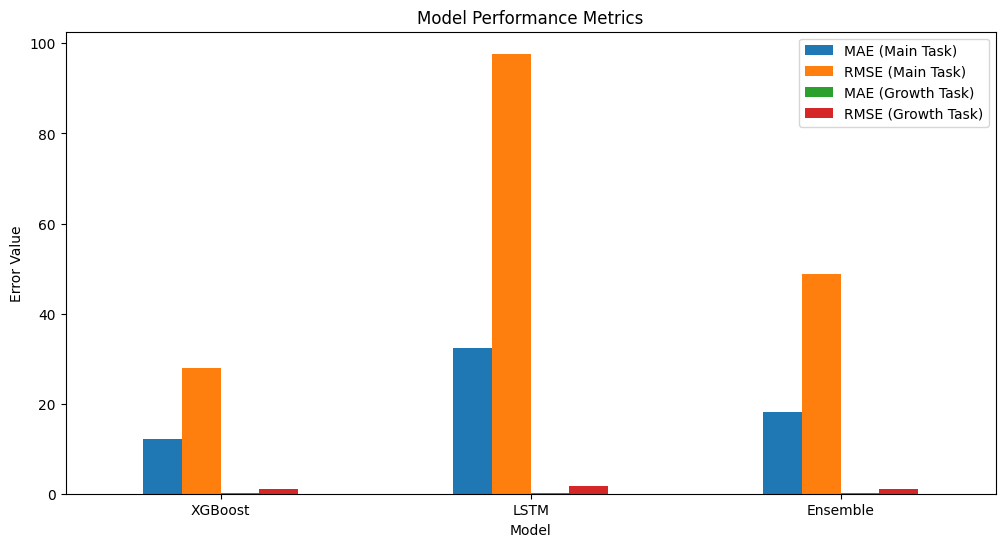

In [ ]:
# Metrics
metrics = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM', 'Ensemble'],
    'MAE (Main Task)': [mean_absolute_error(y_test_main, y_pred_main_xg),
                        mean_absolute_error(y_test_main, y_pred_main_lstm),
                        mae_ensemble_main],
    'RMSE (Main Task)': [np.sqrt(mean_squared_error(y_test_main, y_pred_main_xg)),
                         np.sqrt(mean_squared_error(y_test_main, y_pred_main_lstm)),
                         rmse_ensemble_main],
    'MAE (Growth Task)': [mean_absolute_error(y_test_growth, y_pred_growth_xg),
                          mean_absolute_error(y_test_growth, y_pred_growth_lstm),
                          mae_ensemble_growth],
    'RMSE (Growth Task)': [np.sqrt(mean_squared_error(y_test_growth, y_pred_growth_xg)),
                           np.sqrt(mean_squared_error(y_test_growth, y_pred_growth_lstm)),
                           rmse_ensemble_growth]
})

metrics.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Error Value')
plt.xticks(rotation=0)
plt.show()

# Prediction Plots


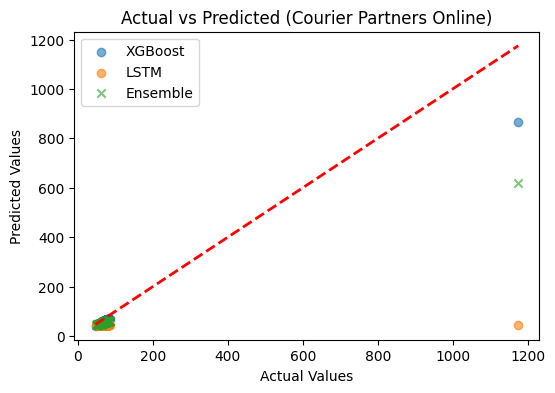

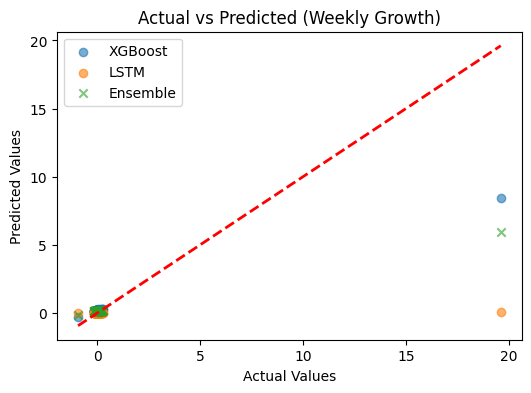

In [ ]:
# 1. Scatter Plots: Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test_main, y_pred_main_xg, label='XGBoost', alpha=0.6)
plt.scatter(y_test_main, y_pred_main_lstm, label='LSTM', alpha=0.6)
plt.scatter(y_test_main, y_pred_main_ensemble, label='Ensemble', alpha=0.6, marker='x')
plt.plot([y_test_main.min(), y_test_main.max()], [y_test_main.min(), y_test_main.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Courier Partners Online)')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test_growth, y_pred_growth_xg, label='XGBoost', alpha=0.6)
plt.scatter(y_test_growth, y_pred_growth_lstm, label='LSTM', alpha=0.6)
plt.scatter(y_test_growth, y_pred_growth_ensemble, label='Ensemble', alpha=0.6, marker='x')
plt.plot([y_test_growth.min(), y_test_growth.max()], [y_test_growth.min(), y_test_growth.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Weekly Growth)')
plt.legend()
plt.show()


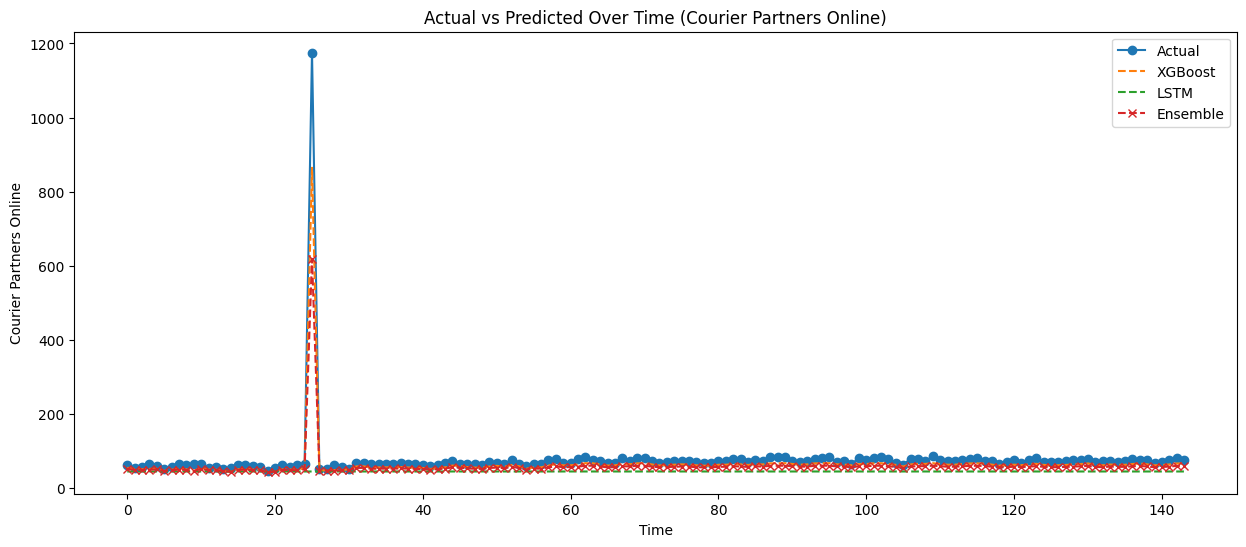

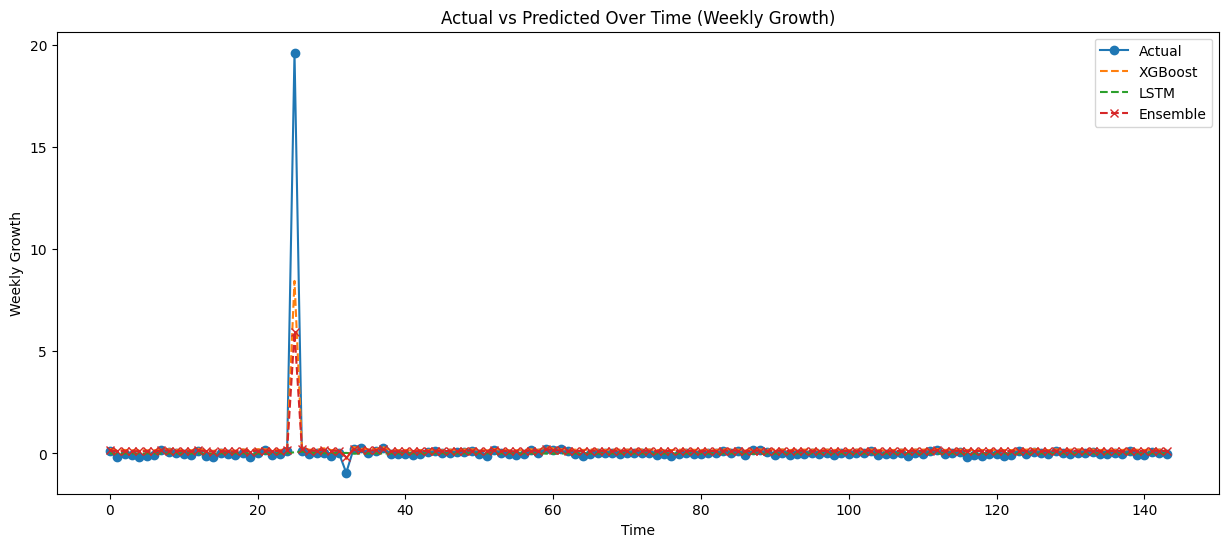

In [ ]:
# 2. Line Plots: Actual vs Predicted Over Time
plt.figure(figsize=(15, 6))
plt.plot(y_test_main.values, label='Actual', marker='o', linestyle='-')
plt.plot(y_pred_main_xg, label='XGBoost', linestyle='--')
plt.plot(y_pred_main_lstm, label='LSTM', linestyle='--')
plt.plot(y_pred_main_ensemble, label='Ensemble', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Courier Partners Online')
plt.title('Actual vs Predicted Over Time (Courier Partners Online)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_growth.values, label='Actual', marker='o', linestyle='-')
plt.plot(y_pred_growth_xg, label='XGBoost', linestyle='--')
plt.plot(y_pred_growth_lstm, label='LSTM', linestyle='--')
plt.plot(y_pred_growth_ensemble, label='Ensemble', linestyle='--', marker='x')
plt.xlabel('Time')
plt.ylabel('Weekly Growth')
plt.title('Actual vs Predicted Over Time (Weekly Growth)')
plt.legend()
plt.show()

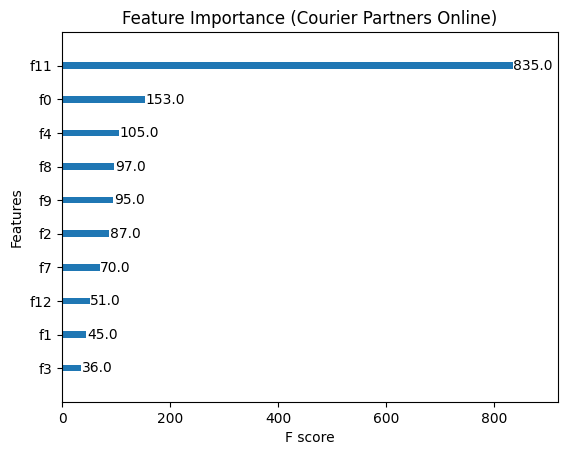

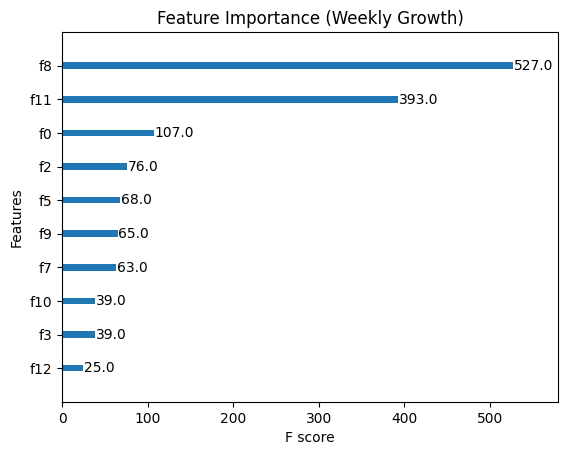

In [ ]:
# Feature Importance
xgb.plot_importance(xgboost_main, max_num_features=10, importance_type='weight', title='Feature Importance (Courier Partners Online)', grid=False)
plt.show()

xgb.plot_importance(xgboost_growth, max_num_features=10, importance_type='weight', title='Feature Importance (Weekly Growth)', grid=False)
plt.show()

In [ ]:
# Forecasting
future_dates = pd.date_range(df['date'].max() + pd.Timedelta(days=1), periods=14, freq='D')
future_df = pd.DataFrame(future_dates, columns=['date'])
future_df['day_of_week'] = future_df['date'].dt.dayofweek
future_df['month'] = future_df['date'].dt.month

# Add the missing features
future_df['day_of_week_sin'] = np.sin(2 * np.pi * future_df['day_of_week'] / 7)
future_df['day_of_week_cos'] = np.cos(2 * np.pi * future_df['day_of_week'] / 7)
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)

# Use the last known values for lag features and moving averages
future_df['lag_1'] = df['courier_partners_online'].iloc[-1]
future_df['lag_7'] = df['courier_partners_online'].iloc[-7]
future_df['rolling_avg_3'] = df['courier_partners_online'].rolling(window=3).mean().iloc[-1]
future_df['rolling_avg_7'] = df['courier_partners_online'].rolling(window=7).mean().iloc[-1]
future_df['exp_moving_avg_3'] = df['courier_partners_online'].ewm(span=3, adjust=False).mean().iloc[-1]
future_df['exp_moving_avg_7'] = df['courier_partners_online'].ewm(span=7, adjust=False).mean().iloc[-1]

# Fill in the remaining required features with constant or mean values
future_df['temperature'] = df['temperature'].mean()
future_df['relative_humidity'] = df['relative_humidity'].mean()
future_df['precipitation'] = 0

future_X = future_df[features_main]
future_X_scaled = scaler_main.transform(future_X)
future_pred_xg = xgboost_main.predict(future_X_scaled)
future_pred_lstm = lstm_main.predict(future_X_scaled.reshape(future_X_scaled.shape[0], future_X_scaled.shape[1], 1))
future_pred_ensemble = 0.7 * future_pred_xg + 0.3 * future_pred_lstm.ravel()
future_df['predicted_courier_partners_online'] = future_pred_ensemble
future_df['upper_bound'] = future_pred_ensemble * 1.1
future_df['lower_bound'] = future_pred_ensemble * 0.9

print(future_df[['date', 'predicted_courier_partners_online', 'upper_bound', 'lower_bound']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
         date  predicted_courier_partners_online  upper_bound  lower_bound
0  2023-06-01                          58.615013    64.476517    52.753510
1  2023-06-02                          58.452427    64.297668    52.607182
2  2023-06-03                          59.639286    65.603218    53.675358
3  2023-06-04                          59.720367    65.692406    53.748329
4  2023-06-05                          59.865788    65.852371    53.879208
5  2023-06-06                          59.971722    65.968895    53.974548
6  2023-06-07                          59.971722    65.968895    53.974548
7  2023-06-08                          58.615013    64.476517    52.753510
8  2023-06-09                          58.452427    64.297668    52.607182
9  2023-06-10                          59.639286    65.603218    53.675358
10 2023-06-11                          59.720367    65.692406    53.748329
11 2023-06-12                          59.865788    65.852371 

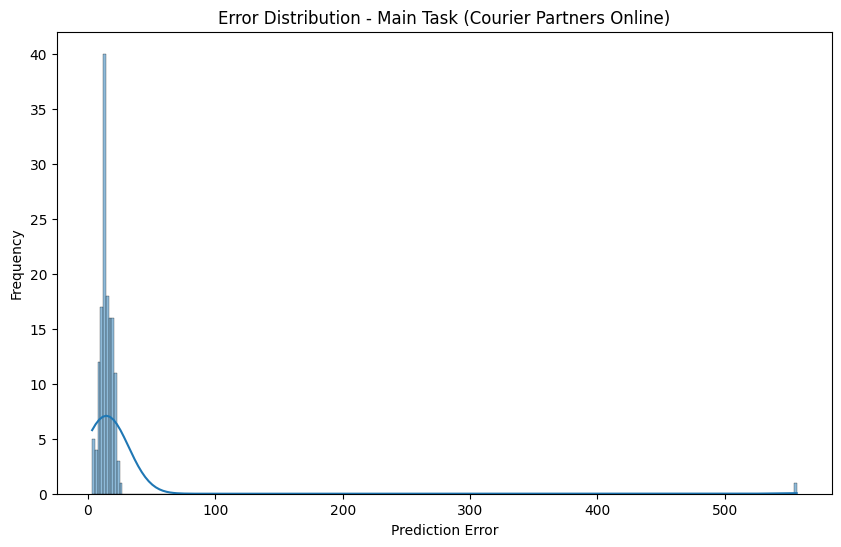

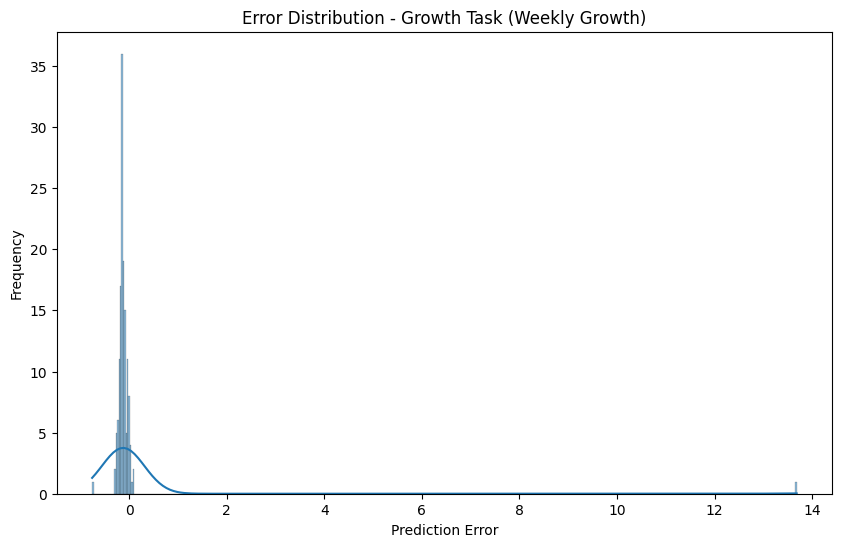

In [ ]:
def plot_error_distribution(y_test, y_pred, title):
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution - {title}')
    plt.show()

plot_error_distribution(y_test_main, y_pred_main_ensemble, 'Main Task (Courier Partners Online)')
plot_error_distribution(y_test_growth, y_pred_growth_ensemble, 'Growth Task (Weekly Growth)')


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Install gradio and plotly if not installed
!pip install gradio plotly pandas --quiet

import pandas as pd
import gradio as gr
import plotly.graph_objs as go

# Updated Forecast Data
forecast_data = pd.DataFrame({
    "date": [
        "2023-06-01", "2023-06-02", "2023-06-03", "2023-06-04",
        "2023-06-05", "2023-06-06", "2023-06-07", "2023-06-08",
        "2023-06-09", "2023-06-10", "2023-06-11", "2023-06-12",
        "2023-06-13", "2023-06-14"
    ],
    "predicted_courier_partners_online": [
        58.615013, 58.452427, 59.639286, 59.720367, 59.865788, 59.971722, 59.971722,
        58.615013, 58.452427, 59.639286, 59.720367, 59.865788, 59.971722, 59.971722
    ],
    "upper_bound": [
        64.476517, 64.297668, 65.603218, 65.692406, 65.852371, 65.968895, 65.968895,
        64.476517, 64.297668, 65.603218, 65.692406, 65.852371, 65.968895, 65.968895
    ],
    "lower_bound": [
        52.753510, 52.607182, 53.675358, 53.748329, 53.879208, 53.974548, 53.974548,
        52.753510, 52.607182, 53.675358, 53.748329, 53.879208, 53.974548, 53.974548
    ]
})

forecast_data['ci_width'] = forecast_data['upper_bound'] - forecast_data['lower_bound']

# Metrics
main_task_mae = 18.16
main_task_rmse = 48.74

# ----------------------------
# Plot 1: Interactive Forecast Line + Area
def interactive_forecast():
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=forecast_data['date'],
        y=forecast_data['predicted_courier_partners_online'],
        mode='lines+markers',
        name='Predicted',
        line=dict(color='royalblue')
    ))
    fig.add_trace(go.Scatter(
        x=forecast_data['date'],
        y=forecast_data['upper_bound'],
        mode='lines',
        name='Upper Bound',
        line=dict(dash='dot', color='lightblue')
    ))
    fig.add_trace(go.Scatter(
        x=forecast_data['date'],
        y=forecast_data['lower_bound'],
        mode='lines',
        name='Lower Bound',
        line=dict(dash='dot', color='lightblue'),
        fill='tonexty',
        fillcolor='rgba(173, 216, 230, 0.2)'
    ))
    fig.update_layout(
        title="📈 Forecast with Confidence Bands",
        xaxis_title="Date",
        yaxis_title="Partners Online",
        hovermode="x unified",
        template="plotly_white",
        height=500,
        margin=dict(l=30, r=30, t=50, b=30)
    )
    return fig

# ----------------------------
# Plot 2: Confidence Interval Width Bar
def confidence_width_bar():
    fig = go.Figure(go.Bar(
        x=forecast_data['date'],
        y=forecast_data['ci_width'],
        marker_color='orange'
    ))
    fig.update_layout(
        title="📏 Confidence Interval Width",
        xaxis_title="Date",
        yaxis_title="Width",
        template="plotly_white",
        height=400,
        margin=dict(l=30, r=30, t=50, b=30)
    )
    return fig

# ----------------------------
# Plot 3: Scatter Plot Predicted
def scatter_predicted():
    fig = go.Figure(go.Scatter(
        x=forecast_data['date'],
        y=forecast_data['predicted_courier_partners_online'],
        mode='markers',
        marker=dict(color='green', size=10)
    ))
    fig.update_layout(
        title="🎯 Scatter Plot of Predictions",
        xaxis_title="Date",
        yaxis_title="Partners Online",
        template="plotly_white",
        height=400,
        margin=dict(l=30, r=30, t=50, b=30)
    )
    return fig

# ----------------------------
# Gradio Dashboard
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("<h1 style='text-align: center;'>🚚 Courier Partners Interactive Dashboard</h1>")
    gr.Markdown("<p style='text-align: center;'>Updated Forecast and Metrics Dashboard - April 2025</p>")

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 📏 Mean Absolute Error (MAE)")
            gr.Markdown(f"<div style='font-size:28px; color:green; text-align:center;'>{main_task_mae:.2f}</div>")
        with gr.Column():
            gr.Markdown("### 📉 Root Mean Square Error (RMSE)")
            gr.Markdown(f"<div style='font-size:28px; color:red; text-align:center;'>{main_task_rmse:.2f}</div>")

    gr.Markdown("---")

    with gr.Tabs():
        with gr.TabItem("📈 Forecast Charts"):
            gr.Markdown("### Forecast with Confidence Intervals")
            gr.Plot(interactive_forecast)
            gr.Markdown("### Confidence Interval Width Over Time")
            gr.Plot(confidence_width_bar)
            gr.Markdown("### Scatter Plot of Predictions")
            gr.Plot(scatter_predicted)

        with gr.TabItem("📋 Forecast Data Table"):
            gr.Markdown("### Forecast Data (Table View)")
            gr.DataFrame(
                value=forecast_data,
                interactive=True,
                row_count=(5, "dynamic"),
                col_count=(4, "dynamic"),
                wrap=True
            )

demo.launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d2002d14265a72c84.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
